## Load relevant libraries

In [ ]:
!pip install ttach

In [1]:
#Imports
import os
import sys
import glob
import torch
import torchvision
import random
import json
from PIL import Image


import numpy as np
import pandas as pd
import random
# import seaborn as sns
from sklearn.metrics import auc,roc_curve
from sklearn.model_selection import train_test_split

# import os
from math import floor
# import torch

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from PIL  import Image
from torch.utils.data  import Dataset

import matplotlib.pyplot as plt
from IPython import display

## Initial config:

In [2]:
## Set he devcide config.

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
%matplotlib inline

def display_thumb(img):
    display.display(transforms.Resize(128)(img))

## Load the datasset from Kaggle:

Upload the kaggle api in colab:

In [4]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


Place it in the root folder:

In [5]:
if not os.path.exists('/root/.kaggle'):
    os.makedirs('/root/.kaggle')

# Move the uploaded kaggle.json file to the Kaggle configuration directory
!chmod 600 kaggle.json
!mv  kaggle.json /root/.kaggle/

In [6]:
## Download the dataset:

# %%capture
!kaggle competitions download -c ammi-2024-computer-vision

100% 2.30G/2.30G [00:13<00:00, 281MB/s]
100% 2.30G/2.30G [00:13<00:00, 183MB/s]


In [7]:
## Unzip the dataset file:
%%capture
!unzip ammi-2024-computer-vision.zip -d /content/CassavaDataset

In [8]:
## Define the paths:
train_path = "/content/CassavaDataset/train/train"
test_path = "/content/CassavaDataset/test/test"

## Visualize the raw images:

In [9]:
cassava_dataset = datasets.ImageFolder("/content/CassavaDataset/train/train")

## Class names:
print("class name %s" %(cassava_dataset.classes))

class name ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']


Label of image: 1 (cbsd). Original size: (625, 500)


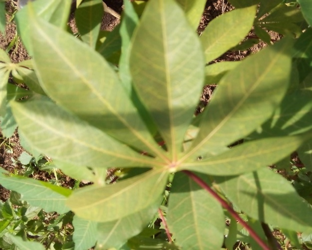

Label of image: 3 (cmd). Original size: (500, 584)


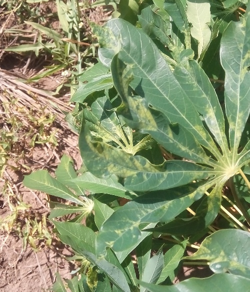

Label of image: 3 (cmd). Original size: (500, 500)


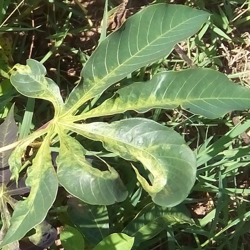

In [10]:
# print("Cassava Leaves classes:", *cassava_dataset.classes)

# Show a random image and the corresponding target.
for i in range(3):
    img, target = random.choice(cassava_dataset)
    print(
        "Label of image: %d (%s). Original size: %s"
        % (target, cassava_dataset.classes[target], img.size)
    )

    # Reduce image size by half to fit the images on the page :)
    display.display(img.resize((img.size[0] // 2, img.size[1] // 2)))

Raw images do not have the same size. They would need to be normalized and have fized size for both training and test tasks. We use one transformation for both test and training. The center crop is also used to fixed the size of the images:

Actual image and its classs: cbsd. Original size: (500, 666)


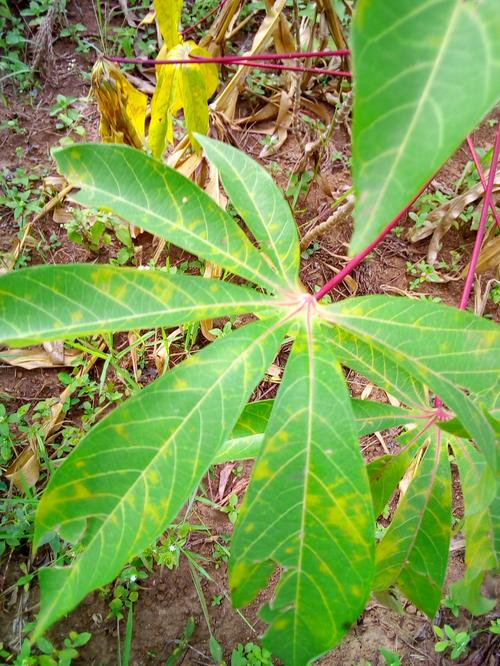

Input to the net for training


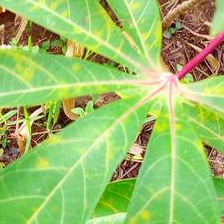

Input to the net for evaluation


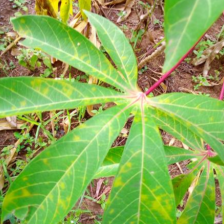

In [11]:
img, target = random.choice(cassava_dataset)
print("Actual image and its classs: %s. Original size: %s"
      %(cassava_dataset.classes[target], img.size)
      )
display.display(img)
print("Input to the net for training")
display.display(transforms.CenterCrop(224)(img))
print("Input to the net for evaluation")
display.display(transforms.CenterCrop(224)(transforms.Resize(256)(img)))

## Transform and Crop.

In [12]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
inference_transform = transforms.Compose(
    [
        # transforms.RandomResizedCrop(224)(img)
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ]
)

In [13]:
class CassavaDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes = os.listdir(path)
        self.path = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform

        files = []
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])
        self.file_list = files
        files = None

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)

        return im.view(3, 224, 224), classCategory

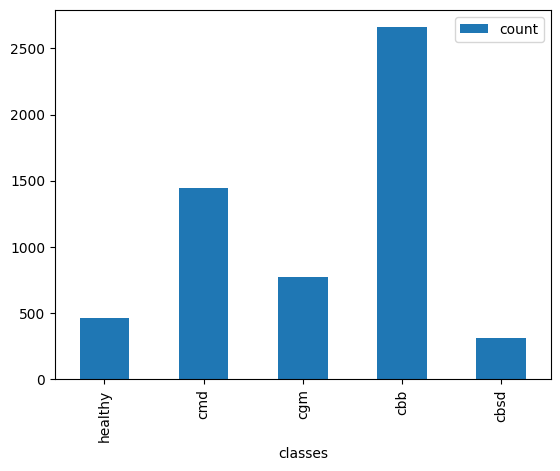

In [14]:
## Dispolay the count of each class:
train_data = CassavaDataset(train_path, transform=inference_transform)
test_data = CassavaDataset(test_path, transform=inference_transform)

class_sample_count = np.unique(cassava_dataset.targets, return_counts=True)[1]

df = pd.DataFrame({"classes":train_data.classes, 'count':class_sample_count})

ax = df.plot.bar(x = "classes", y = "count")

## Split the dataset:

In [15]:
validation_split = .2
shuffle_dataset = True
random_seed= 42
batch_size=32

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [16]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(cassava_dataset, batch_size= batch_size,
                                             sampler=train_sampler, num_workers = 2)
# valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                            #  sampler=valid_sampler, num_workers = 2)
test_loader = torch.utils.data.DataLoader(cassava_dataset, batch_size=batch_size,num_workers = 2)

## Train and test:

In [17]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [18]:
percent_train_ls = []
percent_test_ls = []

def train(model, criterion, data_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model."""


    # Make sure model is in training mode.
    model.train()

    # Move model to the device (CPU or GPU).
    model.to(device)

    # Exponential moving average of the loss.
    ema_loss = None
    ema_loss_ls = []
    losses_train = []

    correct = 0
    train_size = len(data_loader)*batch_size
    train_size = len(data_loader)*batch_size

    print('----- Training Loop -----')
    # Loop over epochs.
    for epoch in range(num_epochs):

      # Loop over data.
      for batch_idx, (features, target) in enumerate(data_loader):

         # To the device
        features = features.to(device)
        target = target.to(device)

          # Forward pass.
        output = model(features)
        loss = criterion(output, target)

          # Backward pass.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      ## Compute accuracy:
        losses_train.append(loss.item())


        # correct +=pred.cpu().eq(target.view_as(pred)).sum().item()
        correct+= accuracy(output, target)[0].item() * features.size(0) / 100

    # Compute the train accuract:

    percent = correct / train_size * 100.
    percent_train_ls.append(percent)

    # Print out progress the end of epoch.
    # print('Epoch: {} \tLoss: {:.6f}'.format(epoch, ema_loss),)
    print("------- train accuracy ---------")
    print('Train accuracy: {:.2f}%'.format(percent),)
    # Plot the training loss
    # plot_train_loss(ema_loss_ls)



##Code added, May 16, 2024 (08:10 am)

def plot_train_loss(ls):
        # Plot the training and test losses
        plt.title("Training loss curves")
        plt.plot(ls, label='Training Loss')
        # plt.plot(ema_test_loss_ls, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        # plt.legend()
        plt.show()

In [19]:
def test(model, data_loader):
    """Measures the accuracy of a model on a data set."""
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0
    losses_test = []
    test_size = len(data_loader)*batch_size

    valid_loss_min = np.inf

    print('----- Model Evaluation -----')
    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():

        # Loop over test data.
        for features, target in data_loader:
            features = features.to(device)
            target = target.to(device)

            # Forward pass.
            output = model(features)
            loss = criterion(output, target)

            # store losses:
            losses_test.append(loss.item())

            # Get the label corresponding to the highest predicted probability.
            # pred = output.argmax(dim=1, keepdim=True)

            # Compute the accuracy:
            correct += accuracy(output, target)[0].item() * features.size(0) / 100

            # Count number of correct predictions.
            # correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    percent = correct / test_size * 100.
    valid_loss = np.mean(losses_test)
    percent_test_ls.append(percent) ## top_1_test
    print('Test accuracy: {:.2f}%'.format(percent)) #correct} / {len(data_loader.dataset)} ({percent:.0f}%)')

    if valid_loss <= np.inf:

      # print(f'Test accuracy: {correct} / {len(data_loader.dataset)} ({percent:.0f}%)')
      torch.save(model.state_dict(), 'model.ckpt')
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
      # return percent

### Use of pre-trained models:

In [20]:
## Load the resnext mode:
%%capture
model = models.resnext101_32x8d(pretrained=True)

In [21]:
##Print the model's details:
%%capture
print(model)

In [22]:
## No grad for some layers:
for param in model.parameters():
    param.requires_grad = False

for param in model.layer3[21:].parameters():
    param.requires_grad = True
for param in model.layer4[1:].parameters():
    param.requires_grad = True


## Modify the last layer from a fc to a sequential:
model.fc = nn.Sequential(
      nn.Linear(2048, 5),
      )

In [23]:
## Print number of parameters:
print('Number of parameters: {:,}'.format(sum(param.numel() for param in model.parameters() if param.requires_grad)))

Number of parameters: 23,967,749


#### Run the pretrained:

In [24]:
num_epochs = 5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=2e-3, momentum=0.9, weight_decay=1e-3)

## Train
train(model, criterion, train_loader, optimizer, num_epochs)

## Test
test(model,test_loader)

----- Training Loop -----


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


------- train accuracy ---------
Train accuracy: 453.65%
----- Model Evaluation -----
Test accuracy: 6.01%
Validation loss decreased (inf --> 9.048020).  Saving model ...


Display the accuracy:

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

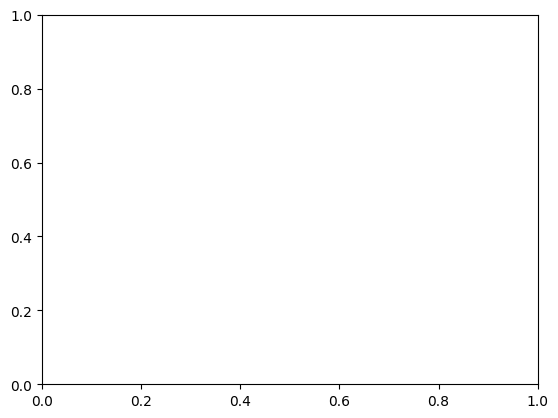

In [25]:
plt.plot(np.arange(num_epochs), percent_train_ls, label='Train')
plt.plot(np.arange(num_epochs), percent_test_ls, label='Test')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy plot for model= resnext101/50')
plt.legend()
plt.show()

## Submissiom:

In [ ]:
subm_sample = pd.read_csv("/content/CassavaDataset/sample_submission_file.csv")
subm_sample.head()

In [ ]:
imgs = os.listdir(test_path)
imgs[:10]

In [ ]:
import json

with open('submission_dict_101_50.json', 'w') as fp:
    json.dump(submission_dict_101, fp)

In [ ]:
import ttach as tta
from PIL import Image
model.load_state_dict(torch.load('/content/drive/My Drive/AMMI_CV/project/state_dict_model_101_final.pt'))
model.to(device)
model.eval()

In [ ]:
ubmission = pd.DataFrame.from_dict(submission_dict_101, orient='index', columns=submision_sample.columns[1:])

submission.reset_index(inplace=True)